# Introduction
The competition is to predict the highest future returns for stocks that are actually traded on the Japan Exchange Group, Inc.
In this notebook, we will work with `jpx_tokyo_market_prediction`, which is unfamiliar to Kaggle beginners, and how to extract the relevant data in the training data.

# Table of Contents
*  [Explanation of data](#Explanation-of-data)
*  [jpx_tokyo_market_prediction](#jpx_tokyo_market_prediction)
*  [Create models and submit data](#Create-models-and-submit-data)

# TODO
* add sharp ratio metrics for evaluation
* improve prediction with dataframe operation
* use qlib data preprocessor

# pytorch gpu check

In [1]:
# check gpu env with torch

import torch

print(torch.__version__)  # 查看torch当前版本号

print(torch.version.cuda)  # 编译当前版本的torch使用的cuda版本号

print("is_cuda_available:", torch.cuda.is_available())  # 查看当前cuda是否可用于当前版本的Torch，如果输出
print('gpu count:', torch.cuda.device_count())
# 查看指定GPU的容量、名称
device = "cuda:0"

print(f"{device} capability:", torch.cuda.get_device_capability(device))

print(f"{device} name:", torch.cuda.get_device_name(device))

1.8.2+cu111
11.1
is_cuda_available: True
gpu count: 2
cuda:0 capability: (8, 6)
cuda:0 name: NVIDIA GeForce RTX 3090


# Explanation of data
## Loading Modules
First, load the required modules.  
In this case, we will use pandas to load the data.

In [2]:
import numpy as np
import pandas as pd

## Check the data
Read *`stock_price.csv`* using `read_csv` in pandas.

In [3]:
stock_price_df = pd.read_csv("/mnt/d/dataset/quant/kaggle22/train_files/stock_prices.csv")
test_stock_price_df = pd.read_csv("/mnt/d/dataset/quant/kaggle22/supplemental_files/stock_prices.csv")

# stock_price_df = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction//train_files/stock_prices.csv")
# test_stock_price_df = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")

In [5]:
train_df = preprocess(stock_price_df, stdsc, is_fit=True)
test_df = preprocess(test_stock_price_df, stdsc, is_fit=False)
train_df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,0.038994,0.035493,0.047764,0.041374,-0.169192,-0.007493,-0.053484,-0.025162,0.000730
1,20170104_1332,2017-01-04,1332,-0.566509,-0.566547,-0.565510,-0.565637,0.537161,-0.007493,-0.053484,-0.025162,0.012324
2,20170104_1333,2017-01-04,1333,0.155286,0.161205,0.163796,0.172227,-0.108081,-0.007493,-0.053484,-0.025162,0.006154
3,20170104_1376,2017-01-04,1376,-0.303174,-0.297439,-0.297504,-0.291909,-0.174323,-0.007493,-0.053484,-0.025162,0.011053
4,20170104_1377,2017-01-04,1377,0.188832,0.199886,0.200587,0.205779,-0.138713,-0.007493,-0.053484,-0.025162,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,-0.581605,-0.579809,-0.579661,-0.577660,-0.165925,-0.007493,-0.053484,-0.025162,0.034816
2332527,20211203_9991,2021-12-03,9991,-0.506685,-0.506316,-0.503532,-0.503287,-0.168043,-0.007493,-0.053484,-0.025162,0.025478
2332528,20211203_9993,2021-12-03,9993,-0.252855,-0.258758,-0.259298,-0.265347,-0.175369,-0.007493,-0.053484,-0.025162,-0.004302
2332529,20211203_9994,2021-12-03,9994,-0.057730,-0.063696,-0.051288,-0.057325,-0.175548,-0.007493,-0.053484,-0.025162,0.009098


## define metric: sharp rate and compute for the training data with known Target

In [6]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2, rank='Rank') -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio, rank='Rank'):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df[rank].min() == 0
        assert df[rank].max() == len(df[rank]) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by=rank)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by=rank, ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio, rank)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [7]:
# add rank according to Target for train

train_df['Rank'] = train_df.groupby("Date")['Target'].transform('rank', ascending=False, method="first") - 1
train_df['Rank'] = train_df['Rank'].astype(int)
# print(train_df['Rank'].min())
df_astock = train_df[train_df['Date'] == '2021-12-03']

# make sure it's correct
print(df_astock['Rank'].min(), df_astock['Rank'].max())
df_astock.sort_values(by=['Target'], ascending=False)
# sharp = calc_spread_return_sharpe(train_df)

0 1994


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
2331270,20211203_4699,2021-12-03,4699,-0.127058,-0.123375,-0.125719,-0.121353,-0.172179,-0.007493,-0.053484,39.742988,0.187970,0
2330587,20211203_1873,2021-12-03,1873,-0.629687,-0.628437,-0.628621,-0.626870,-0.155714,-0.007493,-0.053484,-0.025162,0.186782,1
2331721,20211203_6779,2021-12-03,6779,-0.289755,-0.288598,-0.303447,-0.293027,-0.044672,-0.007493,-0.053484,-0.025162,0.159624,2
2331997,20211203_7809,2021-12-03,7809,0.968774,1.050865,0.925083,1.066947,-0.165388,-0.007493,-0.053484,-0.025162,0.136667,3
2330836,20211203_3031,2021-12-03,3031,-0.392350,-0.396075,-0.397971,-0.402351,0.244368,-0.007493,-0.053484,-0.025162,0.119069,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331784,20211203_6958,2021-12-03,6958,-0.577970,-0.579809,-0.582491,-0.581575,-0.065910,-0.007493,-0.053484,-0.025162,-0.058201,1990
2332479,20211203_9790,2021-12-03,9790,0.343982,0.349084,0.356240,0.353967,-0.171285,-0.007493,-0.053484,-0.025162,-0.084321,1991
2330656,20211203_2158,2021-12-03,2158,0.142707,0.170875,-0.055533,-0.064035,2.842232,-0.007493,-0.053484,-0.025162,-0.091797,1992
2331698,20211203_6718,2021-12-03,6718,-0.122585,-0.114534,-0.121191,-0.111847,-0.164546,-0.007493,-0.053484,-0.025162,-0.092211,1993


In [8]:
tmpdf = test_df.copy()
tmpdf["Close_shift1"] = tmpdf["Close"].shift(-1)
tmpdf["Close_shift2"] = tmpdf["Close"].shift(-2)

tmpdf["rate"] = (tmpdf["Close_shift2"] - tmpdf["Close_shift1"]) / tmpdf["Close_shift1"]
tmpdf.fillna(value={'rate': 0.}, inplace=True)

tmpdf['Rank'] = tmpdf.groupby("Date")['Target'].transform('rank', ascending=False, method="first") - 1
tmpdf['Rank'] = tmpdf['Rank'].astype(int)
tmpdf

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Close_shift1,Close_shift2,rate,Rank
0,20211206_1301,2021-12-06,1301,0.069915,0.061486,0.076114,0.068435,-0.258364,0.010497,-0.039402,-0.05215,-0.003263,-0.492081,-0.071341,-0.855021,1389
1,20211206_1332,2021-12-06,1332,-0.491403,-0.491636,-0.490380,-0.492081,0.331465,0.010497,-0.039402,-0.05215,-0.008993,-0.071341,-0.342657,3.803073,1664
2,20211206_1333,2021-12-06,1333,-0.074290,-0.076388,-0.068072,-0.071341,-0.207317,0.010497,-0.039402,-0.05215,-0.009963,-0.342657,-0.312773,-0.087215,1706
3,20211206_1375,2021-12-06,1375,-0.341562,-0.343084,-0.338807,-0.342657,-0.226863,0.010497,-0.039402,-0.05215,-0.015032,-0.312773,0.122321,-1.391088,1838
4,20211206_1376,2021-12-06,1376,-0.315962,-0.312213,-0.311399,-0.312773,-0.259542,0.010497,-0.039402,-0.05215,0.002867,0.122321,-0.186174,-2.522007,978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111995,20220228_9990,2022-02-28,9990,-0.510427,-0.510437,-0.509208,-0.509259,-0.209630,0.010497,-0.039402,-0.05215,-0.013592,-0.437253,-0.254180,-0.418690,786
111996,20220228_9991,2022-02-28,9991,-0.437150,-0.439178,-0.436519,-0.437253,-0.255179,0.010497,-0.039402,-0.05215,-0.020581,-0.254180,-0.027102,-0.893373,1119
111997,20220228_9993,2022-02-28,9993,-0.254663,-0.254186,-0.249197,-0.254180,-0.260502,0.010497,-0.039402,-0.05215,0.005762,-0.027102,-0.457961,15.897421,136
111998,20220228_9994,2022-02-28,9994,-0.027317,-0.034608,-0.025173,-0.027102,-0.258320,0.010497,-0.039402,-0.05215,-0.002341,-0.457961,NaN,0.000000,330


In [9]:
test_df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,0.069915,0.061486,0.076114,0.068435,-0.258364,0.010497,-0.039402,-0.05215,-0.003263
1,20211206_1332,2021-12-06,1332,-0.491403,-0.491636,-0.490380,-0.492081,0.331465,0.010497,-0.039402,-0.05215,-0.008993
2,20211206_1333,2021-12-06,1333,-0.074290,-0.076388,-0.068072,-0.071341,-0.207317,0.010497,-0.039402,-0.05215,-0.009963
3,20211206_1375,2021-12-06,1375,-0.341562,-0.343084,-0.338807,-0.342657,-0.226863,0.010497,-0.039402,-0.05215,-0.015032
4,20211206_1376,2021-12-06,1376,-0.315962,-0.312213,-0.311399,-0.312773,-0.259542,0.010497,-0.039402,-0.05215,0.002867
...,...,...,...,...,...,...,...,...,...,...,...,...
111995,20220228_9990,2022-02-28,9990,-0.510427,-0.510437,-0.509208,-0.509259,-0.209630,0.010497,-0.039402,-0.05215,-0.013592
111996,20220228_9991,2022-02-28,9991,-0.437150,-0.439178,-0.436519,-0.437253,-0.255179,0.010497,-0.039402,-0.05215,-0.020581
111997,20220228_9993,2022-02-28,9993,-0.254663,-0.254186,-0.249197,-0.254180,-0.260502,0.010497,-0.039402,-0.05215,0.005762
111998,20220228_9994,2022-02-28,9994,-0.027317,-0.034608,-0.025173,-0.027102,-0.258320,0.010497,-0.039402,-0.05215,-0.002341


In [10]:
sharp_train = calc_spread_return_sharpe(train_df)
sharp_test = calc_spread_return_sharpe(tmpdf)
print(f"train={sharp_train}, test={sharp_test}")

train_df.drop(['Rank'], axis=1, inplace=True)

train=4.147729138076841, test=5.430028145273522


Check the form of this data (nrows ,columns) and the contents.

The data contained in `stock_price.csv` was as follows.  
*  `SecuritiesCode` ... Securities Code (number assigned to each stock)
*  `Open` ... Opening price (price per share at the beginning of the day (9:00 am))
*  `High` ... High ... the highest price of the day
*  `Low` ... Low price
*  `Colse` ... Closing price
*  `Volume` ... Volume (number of shares traded in a day)
*  `AdjustmentFactor` ... Used to calculate the theoretical stock price and volume at the time of a reverse stock split or reverse stock split
*  `ExpectedDividend` ... Expected dividend on ex-rights date
*  `SupercisionFlag` ... Flag for supervised issues and delisted issues
*  `Target` ... Percentage change in adjusted closing price (from one day to the next)  
  
Although many other data are available for this competition, we will implement this using only the information in `stock_price.csv`.

# jpx_tokyo_market_prediction
Next, we will check the usage of the API named jpx_tokyo_market_prediction.  
First, import it as you would any other module.  
Since jpx_tokyo_market_prediction can only be executed once, we will write the image in Markdown.

***
```python
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()
```


The environment was created by executing *`make_env()`* and the object was created by executing *`iter_test()`*.
As shown below, looking at the type, iter_test is a generator, so we can confirm that it is an object that can be called one by one with a for statement.  
***
```python
print(type(iter_test))
```
[出力]  
```
<class 'generator'>
```
By turning a for statement, check the operation as follows.
***
```python
count = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    print(prices.head())
    env.predict(sample_prediction)
    count += 1
    break
```
[出力]
```
This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
         Date          RowId  SecuritiesCode    Open    High     Low   Close  \
0  2021-12-06  20211206_1301            1301  2982.0  2982.0  2965.0  2971.0   
1  2021-12-06  20211206_1332            1332   592.0   599.0   588.0   589.0   
2  2021-12-06  20211206_1333            1333  2368.0  2388.0  2360.0  2377.0   
3  2021-12-06  20211206_1375            1375  1230.0  1239.0  1224.0  1224.0   
4  2021-12-06  20211206_1376            1376  1339.0  1372.0  1339.0  1351.0   

    Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag  
0     8900               1.0               NaN            False  
1  1360800               1.0               NaN            False  
2   125900               1.0               NaN            False  
3    81100               1.0               NaN            False  
4     6200               1.0               NaN            False
```

The names of each variable are as follows.  
*  `price` ... Data for each stock on the target day, the same as the information in stock_price.csv without Target.　　
*  `options` ... Same information as options.csv for the target date.
*  `finacials` ... Same information as finacials.csv for the target date.
*  `trades` ... Same information as trades.csv of the target date
*  `secondary_prices` ... Same information as secondary_stock_price.csv without Target for the target date.
*  `sample_prediction` ... Data from sample_prediction.csv for the target date.


Thus, if we call the 2000 stocks of the target date one day at a time using *`jpx_tokyo_market_prediction`*, forecast them with the model we created, and then create the submitted data with env.predict, we can produce a score.

# Create models and submit data
Here, we will create a simple training model using stock_price.csv and implement it up to submission.
## Create Model(LSTM)
We use a model called LSTM (Long Short Term Memory).  
LSTM is one of the RNNs used for series data and is a model that can learn long-term dependencies.  
We will implement LSTM using Pytorch.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LSTM(nn.Module):
    def __init__(self, d_feat=6, hidden_size=64, num_layers=2, dropout=0.0):
        super().__init__()

        self.rnn = nn.LSTM(
            input_size=d_feat,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc_out = nn.Linear(hidden_size, 1)

        self.d_feat = d_feat

    def forward(self, x):
        # x: [N, F*T]
        # x = x.reshape(len(x), self.d_feat, -1)  # [N, F, T]
        # x = x.permute(0, 2, 1)  # [N, T, F]
        out, _ = self.rnn(x)
        
        return self.fc_out(out[:, -1, :]).squeeze(dim=-1)
        

In [12]:
# stock_price_df['ExpectedDividend'] = stock_price_df['ExpectedDividend'].fillna(0)
# stock_price_df['SupervisionFlag'] = stock_price_df['SupervisionFlag'].map({True: 1, False: 0})
# stock_price_df['Date'] = pd.to_datetime(stock_price_df['Date'])
# stock_price_df.info()

Some of them contained missing values, so they were removed.

In [13]:
# stock_price_df = stock_price_df.dropna(how='any')
# # Confirmation of missing information
# stock_price_df_na = (stock_price_df.isnull().sum() / len(stock_price_df)) * 100
# stock_price_df_na = stock_price_df_na.drop(stock_price_df_na[stock_price_df_na == 0].index).sort_values(ascending=False)[:30]
# missing_data = pd.DataFrame({'Missing Ratio' :stock_price_df_na})
# missing_data.head(22)

* 数据预处理是否应该把所有股票放在一起？

stdscStandardize the features (other than RowId, Date, and SecuritiesCode) to be used in this project using sklearn's StandardScaler.

In [14]:
# from sklearn.preprocessing import StandardScaler
# stdsc = StandardScaler()
# columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag']
# stock_price_df[columns] = stdsc.fit_transform(stock_price_df[columns])
# stock_price_df.head()

Store data for each issue in dictionary form and store it in such a way that it can be recalled for each issue.

In [15]:
dataset_dict = {}
for sc in train_df['SecuritiesCode'].unique():
    dataset_dict[str(sc)] = train_df[train_df['SecuritiesCode'] == sc].values[:, 3:].astype(np.float32)
print(dataset_dict['1301'].shape)


(1201, 9)


Use Pytorch dataloader to recall data for each mini-batch.

In [16]:
from torch.utils.data.sampler import SubsetRandomSampler


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, sequence_num=31, y=None, mode='train'):
        self.data = X
        self.teacher = y
        self.sequence_num = sequence_num
        self.mode = mode
    
    def __len__(self):
        return len(self.teacher)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        if self.mode == 'train':
            out_label = self.teacher[idx[-1]]
            return out_data, out_label
        else:
            return out_data

        
def create_dataloader(dataset, dataset_num, sequence_num=31, input_size=8, batch_size=32, shuffle=False):
    sampler = np.array([list(range(i, i+sequence_num)) for i in range(dataset_num-sequence_num+1)])
    if shuffle is True:
        np.random.shuffle(sampler)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)
    return dataloader


In [17]:
test_df.loc[test_df['Date'] == "2021-12-06"]

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,0.069915,0.061486,0.076114,0.068435,-0.258364,0.010497,-0.039402,-0.05215,-0.003263
1,20211206_1332,2021-12-06,1332,-0.491403,-0.491636,-0.490380,-0.492081,0.331465,0.010497,-0.039402,-0.05215,-0.008993
2,20211206_1333,2021-12-06,1333,-0.074290,-0.076388,-0.068072,-0.071341,-0.207317,0.010497,-0.039402,-0.05215,-0.009963
3,20211206_1375,2021-12-06,1375,-0.341562,-0.343084,-0.338807,-0.342657,-0.226863,0.010497,-0.039402,-0.05215,-0.015032
4,20211206_1376,2021-12-06,1376,-0.315962,-0.312213,-0.311399,-0.312773,-0.259542,0.010497,-0.039402,-0.05215,0.002867
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20211206_9990,2021-12-06,9990,-0.506434,-0.507419,-0.507539,-0.509024,-0.233757,0.010497,-0.039402,-0.05215,0.009346
1996,20211206_9991,2021-12-06,9991,-0.443491,-0.444981,-0.443430,-0.445960,-0.249551,0.010497,-0.039402,-0.05215,0.001242
1997,20211206_9993,2021-12-06,9993,-0.244094,-0.246990,-0.242762,-0.247826,-0.259542,0.010497,-0.039402,-0.05215,0.011728
1998,20211206_9994,2021-12-06,9994,-0.068183,-0.065943,-0.060207,-0.061693,-0.258844,0.010497,-0.039402,-0.05215,-0.001230


## Trainig
For each stock, LSTM training is conducted by repeatedly creating a data set and training the model.

To see the learning status, check the phenomenon of the loss function.  
　→Can be learned.

In [27]:
from tqdm import tqdm
import time
import os
import copy

output_dir = "output_lstm"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


epochs = 50
batch_size = 512
seq_len = 14
num_layers = 2
input_size = 5
lstm_dim = 128
dropout = 0.

# Check wheter GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model Instantiation
model = LSTM(d_feat=input_size, hidden_size=lstm_dim, num_layers=num_layers, dropout=dropout)
model.to(device)
model.train()
# setting optimizer
lr = 0.001
weight_decay = 1.0e-05
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)
# setting criterion
criterion = nn.MSELoss()


def train_epoch(train_df, model, seq_len=30, batch_size=512):
    groups = train_df.groupby(['SecuritiesCode'])
    total_loss = 0.
    iteration = 0
    model.train()
    
    def collect_batch_index():  # index for a stock with seq_len continuous days
        batch_index = []
        for sc, group in groups:
            indices = np.arange(len(group))
            for i in range(len(indices))[:: seq_len]:
                if len(indices) - i < seq_len:
                    break
                batch_index.append(group.index[i: i + seq_len])
        return batch_index
            

    batch_index = collect_batch_index() 
    indices = np.arange(len(batch_index))
    np.random.shuffle(indices)
    
    for i in range(len(indices))[:: batch_size]:

        # if len(indices) - i < batch_size:
        #     break
        
        x_train = []
        y_train = []
        for index in indices[i: i + batch_size]:
            values = train_df.loc[batch_index[index]].values
            x_train.append(values[:, 3: 3 + input_size].astype(np.float32))
            y_train.append(values[:, -1][-1])
        
        # print(y_train)
            
        feature = torch.from_numpy(np.vstack(x_train).reshape((len(y_train), seq_len, -1))).float().to(device)
        label = torch.from_numpy(np.vstack(y_train)).flatten().float().to(device)
        # print(feature.size(), label.size())

        pred = model(feature)
        # print(pred.size(), label.size())
        loss = criterion(pred, label)
        total_loss += loss.item()
        
        # if list(label.size())[0] < batch_size:
        #     print('train', pred.size(), label.size(), feature.size())
            
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 3.0)
        optimizer.step()
        iteration += 1
            
    return total_loss/iteration


def test_epoch(train_df, model, seq_len=30, batch_size=512):
    groups = train_df.groupby(['SecuritiesCode'])
    total_loss = 0.
    iteration = 0
    model.eval()
    
    tmp_df = train_df.copy()
    tmp_df['pred'] = 0  # 默认没预测的涨幅都为 0

    def collect_batch_index():  # index for a stock with seq_len continuous days
        batch_index = []
        for sc, group in groups:
            indices = np.arange(len(group))
            for i in range(len(indices))[:: seq_len]:
                if len(indices) - i < seq_len:
                    break
                batch_index.append(group.index[i: i + seq_len])
        return batch_index


    batch_index = collect_batch_index()
    indices = np.arange(len(batch_index))
    
    pre_indices = [index[-1] for index in batch_index]
    pred_array = np.array([])
    
    for i in range(len(indices))[:: batch_size]:

        # if len(indices) - i < batch_size:
        #     break

        x_train = []
        y_train = []
        for index in indices[i: i + batch_size]:
            values = train_df.loc[batch_index[index]].values
            # see the train_df format upstair
            x_train.append(values[:, 3: 3 + input_size].astype(np.float32))
            y_train.append(values[:, -1][-1])

            
        feature = torch.from_numpy(np.vstack(x_train).reshape((len(y_train), seq_len, -1))).float().to(device)
        label = torch.from_numpy(np.vstack(y_train)).flatten().float().to(device)
        

        pred = model(feature)
        
        loss = criterion(pred, label)
        
        # if list(label.size())[0] < batch_size:
        #     print('test', pred.size(), label.size(), feature.size())
        total_loss += loss.item()
        # print(pred)
        pred_array = np.append(pred_array, pred.detach().cpu().numpy())
        iteration += 1

    # print(len(pre_indices), len(pred_array))
    tmp_df.loc[pre_indices, 'pred'] = pred_array
    tmp_df['Rank'] = tmp_df.groupby("Date")['pred'].transform('rank', ascending=False, method="first") - 1
    tmp_df['Rank'] = tmp_df['Rank'].astype(int)
    
    sharp = calc_spread_return_sharpe(tmp_df)
    
    return total_loss/iteration, sharp


log_train = [[0], [np.inf]]
log_eval = [[0], [np.inf]]
best_eval_loss = np.inf
best_model_path = 'Unknown'

if True:
    model.eval()
    train_loss, train_sharp = test_epoch(train_df, model, batch_size=batch_size, seq_len=seq_len)
    test_loss, test_sharp = test_epoch(test_df, model, batch_size=batch_size, seq_len=seq_len)
    print("with training, random train_loss={}, train_sharp={}, eval_loss={}, eval_sharp={}".format(train_loss, train_sharp, test_loss, test_sharp))
    _tqdm = tqdm(range(epochs))
    for epoch in _tqdm:
        epoch_loss = 0.0
        # set iteration counter
        iteration = 0
        start_time = time.time()

        epoch_loss = train_epoch(train_df, model, seq_len=seq_len, batch_size=batch_size)
        end_time = time.time()
    #     print('epoch_loss={}'.format(epoch_loss))

        log_train[0].append(epoch)
        log_train[1].append(epoch_loss)

        # eval
        eval_loss, sharp = test_epoch(test_df, model, seq_len=seq_len, batch_size=batch_size)
        train_loss, train_sharp = test_epoch(train_df, model, seq_len=seq_len, batch_size=batch_size)
        
        log_eval[0].append(epoch)
        log_eval[1].append(eval_loss)
        if best_eval_loss > eval_loss:
            best_eval_loss = eval_loss
            best_model_path = f"{output_dir}/{epoch}.pt"

        # print("epoch {}, run_time={}, train loss={}, eval_loss={}".format(epoch, (end_time - start_time), epoch_loss, eval_loss))
        print("epoch {}, run_time={}, train loss={}, eval_loss={}, eval_sharp={}".format(epoch, (end_time - start_time), epoch_loss, eval_loss, sharp))
        print("\t train_loss={}, train_sharp={}".format(train_loss, train_sharp))
        # _tqdm.set_description("epoch {}, run_time={}, train loss={}, eval_loss={}, eval_sharp={}".format(epoch, (end_time - start_time), epoch_loss, eval_loss, sharp))
        # save mode
        save_path = f"{output_dir}/{epoch}.pt"
        param = copy.deepcopy(model.state_dict())
        torch.save(param, save_path)

with training, random train_loss=0.000734238720120087, train_sharp=0.04209109962156693, eval_loss=0.001237477747054072, eval_sharp=0.05985383647992399


  2%|███▉                                                                                                                                                                                                  | 1/50 [02:32<2:04:40, 152.67s/it]

epoch 0, run_time=73.89934062957764, train loss=0.0005624992571379237, eval_loss=0.0007073952983773779, eval_sharp=-0.09803753233479665
	 train_loss=0.000558936436171065, train_sharp=0.018433095002756333


  4%|███████▉                                                                                                                                                                                              | 2/50 [05:02<2:00:58, 151.21s/it]

epoch 1, run_time=73.82773327827454, train loss=0.0005583647607467051, eval_loss=0.0007490831503673689, eval_sharp=0.05367736800822311
	 train_loss=0.0005574382619060263, train_sharp=0.034508626596503555


  6%|███████████▉                                                                                                                                                                                          | 3/50 [07:33<1:58:12, 150.90s/it]

epoch 2, run_time=74.11204242706299, train loss=0.0005582176210895261, eval_loss=0.0007582023081340594, eval_sharp=-0.10385927765648957
	 train_loss=0.0005581024070237821, train_sharp=0.015686140776172627


  8%|███████████████▊                                                                                                                                                                                      | 4/50 [10:03<1:55:24, 150.54s/it]

epoch 3, run_time=73.75530123710632, train loss=0.0005577685873990196, eval_loss=0.0007184226087701973, eval_sharp=0.010605269355142385
	 train_loss=0.0005576910579129504, train_sharp=0.026116069262780768


 10%|███████████████████▊                                                                                                                                                                                  | 5/50 [12:34<1:52:57, 150.61s/it]

epoch 4, run_time=74.34958052635193, train loss=0.0005578871784581346, eval_loss=0.0007095094424585113, eval_sharp=-0.053568168750496206
	 train_loss=0.0005589593008452714, train_sharp=0.019390794377973183


 12%|███████████████████████▊                                                                                                                                                                              | 6/50 [15:05<1:50:33, 150.77s/it]

epoch 5, run_time=74.29353499412537, train loss=0.0005582938668887877, eval_loss=0.0007607305160490796, eval_sharp=0.05151548619195696
	 train_loss=0.0005576281871766673, train_sharp=0.028628324086737086


 14%|███████████████████████████▋                                                                                                                                                                          | 7/50 [17:36<1:48:07, 150.87s/it]

epoch 6, run_time=74.44740104675293, train loss=0.0005577160165716043, eval_loss=0.0007111627292033518, eval_sharp=0.07292169991766413
	 train_loss=0.000557924909224323, train_sharp=0.03694629339458827


 16%|███████████████████████████████▋                                                                                                                                                                      | 8/50 [20:02<1:44:33, 149.38s/it]

epoch 7, run_time=71.95731210708618, train loss=0.0005581584879810349, eval_loss=0.0007469993233826244, eval_sharp=0.06086014462157764
	 train_loss=0.0005571026175976326, train_sharp=0.02928003614072748


 18%|███████████████████████████████████▋                                                                                                                                                                  | 9/50 [22:33<1:42:24, 149.87s/it]

epoch 8, run_time=74.3683705329895, train loss=0.0005579268076617606, eval_loss=0.0007553175837529125, eval_sharp=0.06775455922184492
	 train_loss=0.0005573443762932019, train_sharp=0.030173550633276095


 20%|███████████████████████████████████████▍                                                                                                                                                             | 10/50 [25:03<1:40:02, 150.06s/it]

epoch 9, run_time=74.1704113483429, train loss=0.0005576050349891544, eval_loss=0.0007283579325303435, eval_sharp=0.07485552019798729
	 train_loss=0.0005573996649845358, train_sharp=0.040530070468550346


 22%|███████████████████████████████████████████▎                                                                                                                                                         | 11/50 [27:35<1:37:51, 150.55s/it]

epoch 10, run_time=75.19064378738403, train loss=0.0005575508277491603, eval_loss=0.0007508639519073768, eval_sharp=0.052355319180367864
	 train_loss=0.0005572190789252039, train_sharp=0.02833925394112974


 24%|███████████████████████████████████████████████▎                                                                                                                                                     | 12/50 [30:05<1:35:18, 150.48s/it]

epoch 11, run_time=73.8664128780365, train loss=0.0005579973577871711, eval_loss=0.0007401747825497296, eval_sharp=0.05211739635461216
	 train_loss=0.0005570265387838579, train_sharp=0.029235806917848342


 26%|███████████████████████████████████████████████████▏                                                                                                                                                 | 13/50 [32:34<1:32:27, 149.94s/it]

epoch 12, run_time=72.88722372055054, train loss=0.0005575453818982513, eval_loss=0.0007560723661299562, eval_sharp=0.04127396265042399
	 train_loss=0.0005574450832744627, train_sharp=0.028851268730471058


 28%|███████████████████████████████████████████████████████▏                                                                                                                                             | 14/50 [35:05<1:30:04, 150.13s/it]

epoch 13, run_time=73.66505861282349, train loss=0.000557896625724193, eval_loss=0.0007287971384357661, eval_sharp=0.07868833465160706
	 train_loss=0.000557444530301684, train_sharp=0.04248056106982454


 30%|███████████████████████████████████████████████████████████                                                                                                                                          | 15/50 [37:41<1:28:37, 151.93s/it]

epoch 14, run_time=74.59049606323242, train loss=0.0005574358279400314, eval_loss=0.0007461178411176661, eval_sharp=0.055988232053929964
	 train_loss=0.0005571287438441184, train_sharp=0.028755567360462236


 32%|███████████████████████████████████████████████████████████████                                                                                                                                      | 16/50 [40:17<1:26:46, 153.14s/it]

epoch 15, run_time=76.53999948501587, train loss=0.0005575799735180559, eval_loss=0.00076121251549921, eval_sharp=0.05417051669287516
	 train_loss=0.0005575288872119554, train_sharp=0.028901195732092013


 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                  | 17/50 [42:53<1:24:47, 154.15s/it]

epoch 16, run_time=75.88414597511292, train loss=0.0005574451586099989, eval_loss=0.0007369642626144923, eval_sharp=0.06537697426995522
	 train_loss=0.0005570047521263777, train_sharp=0.03014478111137218


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                              | 18/50 [45:28<1:22:22, 154.46s/it]

epoch 17, run_time=75.32902383804321, train loss=0.0005576482257966288, eval_loss=0.0007543810988863697, eval_sharp=0.0589132537806705
	 train_loss=0.0005572616777589591, train_sharp=0.029132564441774818


 38%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 19/50 [48:05<1:20:08, 155.10s/it]

epoch 18, run_time=76.9324688911438, train loss=0.0005577236777482415, eval_loss=0.0007291607216757257, eval_sharp=0.06592890267307167
	 train_loss=0.0005571447158816577, train_sharp=0.0318278037927052


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 20/50 [50:39<1:17:27, 154.91s/it]

epoch 19, run_time=74.99009776115417, train loss=0.0005576231607101476, eval_loss=0.0007400504036922939, eval_sharp=0.06269841116030443
	 train_loss=0.0005569965943317391, train_sharp=0.029399780500482257


 42%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 21/50 [53:14<1:14:48, 154.78s/it]

epoch 20, run_time=75.42562007904053, train loss=0.0005576561891288722, eval_loss=0.0007469358115486102, eval_sharp=0.05664017761477171
	 train_loss=0.0005570720609256517, train_sharp=0.028509461343008996


 44%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 22/50 [55:50<1:12:25, 155.20s/it]

epoch 21, run_time=77.24093317985535, train loss=0.0005576433145704315, eval_loss=0.0007330235002882546, eval_sharp=0.051523839601601784
	 train_loss=0.0005570867792840596, train_sharp=0.029631806576542897


 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 23/50 [58:29<1:10:24, 156.46s/it]

epoch 22, run_time=78.27623653411865, train loss=0.0005576527519845722, eval_loss=0.0007248266065289499, eval_sharp=0.049470915311369046
	 train_loss=0.0005573289621544002, train_sharp=0.027755956475121992


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 24/50 [1:01:04<1:07:33, 155.90s/it]

epoch 23, run_time=75.37250924110413, train loss=0.0005573232188026901, eval_loss=0.0007360044819506584, eval_sharp=0.05900515462259212
	 train_loss=0.0005570139812040923, train_sharp=0.029376794208349936


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 25/50 [1:03:42<1:05:09, 156.38s/it]

epoch 24, run_time=76.35905504226685, train loss=0.0005586121794594139, eval_loss=0.0007571923306386452, eval_sharp=0.0688625216186167
	 train_loss=0.0005574651542972912, train_sharp=0.030051778615894795


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 26/50 [1:06:17<1:02:23, 155.98s/it]

epoch 25, run_time=75.45817971229553, train loss=0.0005577184093222369, eval_loss=0.0007402772243949585, eval_sharp=0.05794427661990319
	 train_loss=0.0005570152253024599, train_sharp=0.029768823950561282


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 27/50 [1:08:57<1:00:19, 157.39s/it]

epoch 26, run_time=79.00955772399902, train loss=0.0005576273750713361, eval_loss=0.0007470830641977955, eval_sharp=0.01856816131155461
	 train_loss=0.0005573737007523858, train_sharp=0.0255368867455804


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 28/50 [1:11:35<57:41, 157.34s/it]

epoch 27, run_time=76.13463258743286, train loss=0.0005577921000401842, eval_loss=0.0007470151704183081, eval_sharp=0.06300690737797457
	 train_loss=0.0005570730187309044, train_sharp=0.02894537294916884


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 29/50 [1:14:11<55:00, 157.15s/it]

epoch 28, run_time=77.08276987075806, train loss=0.0005574761404509812, eval_loss=0.0007479410596715752, eval_sharp=0.06400456431257988
	 train_loss=0.000557097078966966, train_sharp=0.030139932341257756


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 30/50 [1:16:48<52:21, 157.08s/it]

epoch 29, run_time=75.85027599334717, train loss=0.0005581898352468201, eval_loss=0.0007316043993341736, eval_sharp=0.06363929180306402
	 train_loss=0.0005570805681922172, train_sharp=0.03046761037735787


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 31/50 [1:19:27<49:54, 157.63s/it]

epoch 30, run_time=77.63250374794006, train loss=0.0005575164657965394, eval_loss=0.0007352147222263739, eval_sharp=0.062311602603139046
	 train_loss=0.000557024067489037, train_sharp=0.028552752903438713


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 32/50 [1:22:04<47:16, 157.57s/it]

epoch 31, run_time=76.8289623260498, train loss=0.0005578039919376165, eval_loss=0.0007444800467055757, eval_sharp=0.06220033104122154
	 train_loss=0.0005570374988616005, train_sharp=0.028387298299133605


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 33/50 [1:24:41<44:35, 157.36s/it]

epoch 32, run_time=75.91895842552185, train loss=0.0005573439691107292, eval_loss=0.0007313299047382316, eval_sharp=0.03740245027127617
	 train_loss=0.0005572262853770864, train_sharp=0.027574828947250156


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 34/50 [1:27:16<41:45, 156.60s/it]

epoch 33, run_time=75.78026866912842, train loss=0.0005575974247894128, eval_loss=0.0007404208063235274, eval_sharp=0.06733484042795944
	 train_loss=0.000557019303860837, train_sharp=0.030512840084385005


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 35/50 [1:29:51<39:00, 156.02s/it]

epoch 34, run_time=75.55309391021729, train loss=0.0005579469637816587, eval_loss=0.000750496685213875, eval_sharp=0.0644173684664807
	 train_loss=0.0005571492689138174, train_sharp=0.030216325826747773


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 36/50 [1:32:25<36:16, 155.50s/it]

epoch 35, run_time=75.32653403282166, train loss=0.0005572477703760754, eval_loss=0.0007346394613705343, eval_sharp=0.04825730201017087
	 train_loss=0.0005570848826543133, train_sharp=0.029178844928308877


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 37/50 [1:35:01<33:44, 155.76s/it]

epoch 36, run_time=75.75541496276855, train loss=0.0005573709260365746, eval_loss=0.000736224748834502, eval_sharp=0.06329410161488051
	 train_loss=0.0005570293069015957, train_sharp=0.029225956176869475


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 38/50 [1:37:35<31:01, 155.16s/it]

epoch 37, run_time=74.7986912727356, train loss=0.0005574473084973009, eval_loss=0.0007346772836172022, eval_sharp=0.04668713845763286
	 train_loss=0.0005570827624131492, train_sharp=0.02981055963205193


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 39/50 [1:40:08<28:20, 154.56s/it]

epoch 38, run_time=74.07793641090393, train loss=0.000557661343851092, eval_loss=0.0007271641625266057, eval_sharp=0.05873135578219239
	 train_loss=0.0005572029480367887, train_sharp=0.02856286355363293


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 40/50 [1:42:42<25:41, 154.15s/it]

epoch 39, run_time=74.6655285358429, train loss=0.0005575626532139361, eval_loss=0.0007293764865607955, eval_sharp=0.06665018035369324
	 train_loss=0.0005571554401912582, train_sharp=0.032478246564918045


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 41/50 [1:45:16<23:07, 154.15s/it]

epoch 40, run_time=75.04722285270691, train loss=0.0005572993345001875, eval_loss=0.0007193938472482841, eval_sharp=0.06226522610403223
	 train_loss=0.0005574921716452194, train_sharp=0.029218543175350754


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 42/50 [1:47:49<20:30, 153.81s/it]

epoch 41, run_time=74.40124130249023, train loss=0.0005574186792762036, eval_loss=0.0007431535395880928, eval_sharp=0.0633663075872981
	 train_loss=0.0005570296837600463, train_sharp=0.02998792870517568


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 43/50 [1:50:20<17:52, 153.17s/it]

epoch 42, run_time=74.05648946762085, train loss=0.0005578652667987987, eval_loss=0.0007556592045148136, eval_sharp=0.06122589002631041
	 train_loss=0.0005573253357448176, train_sharp=0.028633353040840092


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 44/50 [1:52:52<15:16, 152.72s/it]

epoch 43, run_time=73.93094372749329, train loss=0.0005578771901500602, eval_loss=0.0007469177180610131, eval_sharp=0.06279364245860249
	 train_loss=0.0005570778648802137, train_sharp=0.029379187994158437


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 45/50 [1:55:25<12:44, 152.84s/it]

epoch 44, run_time=74.91890239715576, train loss=0.0005572683848361109, eval_loss=0.0007307904706976842, eval_sharp=0.06367935315075372
	 train_loss=0.0005571043037669155, train_sharp=0.029603448149524435


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 46/50 [1:57:58<10:11, 152.82s/it]

epoch 45, run_time=74.50799441337585, train loss=0.000557525171186075, eval_loss=0.0007473753321391996, eval_sharp=0.06390591756104687
	 train_loss=0.0005570897813622481, train_sharp=0.02967950518056667


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 47/50 [2:00:32<07:39, 153.13s/it]

epoch 46, run_time=74.69656300544739, train loss=0.0005573245024443054, eval_loss=0.0007445434039254906, eval_sharp=0.06088990726315684
	 train_loss=0.0005570526890726384, train_sharp=0.028404997865814754


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 48/50 [2:03:02<05:04, 152.37s/it]

epoch 47, run_time=74.73951601982117, train loss=0.0005573821332709146, eval_loss=0.0007259069298015675, eval_sharp=0.06515908844563374
	 train_loss=0.0005572584344895545, train_sharp=0.03438855580098056


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 49/50 [2:05:33<02:31, 151.73s/it]

epoch 48, run_time=72.50665831565857, train loss=0.0005576550337429569, eval_loss=0.0007546218803327065, eval_sharp=0.06173431177772263
	 train_loss=0.0005572896232208098, train_sharp=0.028457214605901306


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [2:08:05<00:00, 153.71s/it]

epoch 49, run_time=73.99673342704773, train loss=0.0005578000221570653, eval_loss=0.0007426362026308198, eval_sharp=0.06612586393590573
	 train_loss=0.000557039191041457, train_sharp=0.030196396299109116


In [28]:
print(best_model_path)
# best_model_path = "output_lstm/17.pt"
model.load_state_dict(torch.load(best_model_path))

output_lstm/0.pt


<All keys matched successfully>

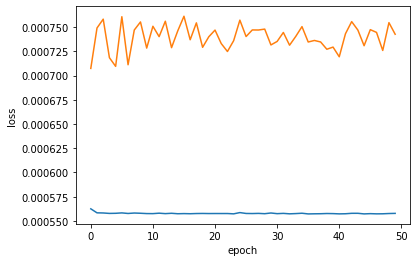

In [29]:
import matplotlib.pyplot as plt
plt.plot(log_train[0][1:], log_train[1][1:])
plt.plot(log_eval[0][1:], log_eval[1][1:])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Prediction
The trained model will be used to make predictions on the submitted data.  
`DataFrame` → `Ndarray` → `tensor` and transform the data to make predictions.

## Submission
Perform data preparation for submission from `jpx_tokyo_market_prediction`.

In [22]:
import sys
sys.path.append("/mnt/d/dataset/quant/kaggle22/")

import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.7 of module 'jpx_tokyo_market_prediction.competition' does not match runtime version 3.8


In [23]:
count = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    prices = prices.fillna(0)
    prices['SupervisionFlag'] = prices['SupervisionFlag'].map({True: 1, False: 0})
    prices['Date'] = pd.to_datetime(prices['Date'])
    pred_df = predict(model, prices)
    # print(pred_df)
    env.predict(pred_df)
    count += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
input size torch.Size([512, 30, 5])
input size torch.Size([512, 30, 5])
input size torch.Size([512, 30, 5])
input size torch.Size([464, 30, 5])


/tmp/ipykernel_15229/3863093181.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['target'] = y_pred
/tmp/ipykernel_15229/3863093181.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Rank'] = pred_df["target"].rank(ascending=False, method="first") - 1
/tmp/ipykernel_15229/3863093181.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

input size torch.Size([512, 30, 5])
input size torch.Size([512, 30, 5])
input size torch.Size([512, 30, 5])
input size torch.Size([464, 30, 5])


/tmp/ipykernel_15229/3863093181.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['target'] = y_pred
/tmp/ipykernel_15229/3863093181.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Rank'] = pred_df["target"].rank(ascending=False, method="first") - 1
/tmp/ipykernel_15229/3863093181.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [24]:
pred_df

,Date,SecuritiesCode,Rank
0,2021-12-07,1301,1561
1,2021-12-07,1332,19
2,2021-12-07,1333,1331
3,2021-12-07,1375,722
4,2021-12-07,1376,825
...,...,...,...
1995,2021-12-07,9990,253
1996,2021-12-07,9991,440
1997,2021-12-07,9993,996
1998,2021-12-07,9994,1378
